# LBPH Training - Kaggle

Notebook huấn luyện LBPH (Local Binary Patterns Histograms) trên Kaggle.

## Chuẩn bị:
1. Upload dataset `celeba-aligned-balanced` lên Kaggle Datasets
2. Add dataset vào notebook này
3. Accelerator: CPU (LBPH không cần GPU)

In [1]:
# Detect môi trường
import os
import sys

IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
print(f"Kaggle environment: {IS_KAGGLE}")

if not IS_KAGGLE:
    print("WARNING: Notebook này được thiết kế cho Kaggle!")

Kaggle environment: True


In [2]:
# Cấu hình đường dẫn Kaggle
ROOT = "/kaggle/working/FaceRecognition"
CHECKPOINT_DIR = "/kaggle/working/checkpoints/lbph"

# Dataset path
KAGGLE_DATASET_NAME = "celeba-aligned-balanced"
DATA_DIR = f"/kaggle/input/{KAGGLE_DATASET_NAME}/CelebA_Aligned_Balanced"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"ROOT: {ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"CHECKPOINT_DIR: {CHECKPOINT_DIR}")

ROOT: /kaggle/working/FaceRecognition
DATA_DIR: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced
CHECKPOINT_DIR: /kaggle/working/checkpoints/lbph


In [3]:
# === CAU HINH CHECKPOINT DATASET (optional) ===
CHECKPOINT_DATASET_NAME = ""

import shutil
import glob

if CHECKPOINT_DATASET_NAME:
    checkpoint_input_dir = f"/kaggle/input/{CHECKPOINT_DATASET_NAME}"
    if os.path.exists(checkpoint_input_dir):
        print("[OK] Tim thay checkpoint dataset")
        xml_files = glob.glob(os.path.join(checkpoint_input_dir, "**/*.xml"), recursive=True)
        if xml_files:
            os.makedirs(CHECKPOINT_DIR, exist_ok=True)
            for xml_file in xml_files:
                dest_path = os.path.join(CHECKPOINT_DIR, os.path.basename(xml_file))
                if not os.path.exists(dest_path):
                    shutil.copy(xml_file, dest_path)
                    print(f"[COPY] {os.path.basename(xml_file)}")
else:
    print("[INFO] Training tu dau (khong co checkpoint)")

[INFO] Training tu dau (khong co checkpoint)


In [4]:
# Kiểm tra Kaggle dataset
print("=== KAGGLE INPUT DATASETS ===")
!ls -la /kaggle/input/

if os.path.exists(DATA_DIR):
    print(f"\n[OK] Dataset found at: {DATA_DIR}")
    !ls -la {DATA_DIR}
else:
    print(f"\n[ERROR] Dataset not found at: {DATA_DIR}")

=== KAGGLE INPUT DATASETS ===
total 8
drwxr-xr-x 3 root   root    4096 Dec 19 00:48 .
drwxr-xr-x 5 root   root    4096 Dec 19 00:48 ..
drwxr-xr-x 3 nobody nogroup    0 Dec 17 17:44 celeba-aligned-balanced

[OK] Dataset found at: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced
total 0
drwxr-xr-x    6 nobody nogroup 0 Dec 17 17:44 .
drwxr-xr-x    3 nobody nogroup 0 Dec 17 17:44 ..
drwxr-xr-x    2 nobody nogroup 0 Dec 17 17:44 metadata
drwxr-xr-x 9345 nobody nogroup 0 Dec 17 17:45 test
drwxr-xr-x 9345 nobody nogroup 0 Dec 17 17:45 train
drwxr-xr-x 9345 nobody nogroup 0 Dec 17 17:45 val


In [5]:
# Cau hinh GitHub token
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    GITHUB_TOKEN = user_secrets.get_secret("GITHUB_TOKEN")
    print("[OK] Da lay GITHUB_TOKEN")
except Exception as e:
    GITHUB_TOKEN = None
    print("[INFO] Su dung public URL")

if GITHUB_TOKEN:
    REPO_URL = f"https://{GITHUB_TOKEN}@github.com/sin0235/FaceRecognition.git"
else:
    REPO_URL = "https://github.com/sin0235/FaceRecognition.git"

[OK] Da lay GITHUB_TOKEN


In [6]:
# Clone repository
if os.path.exists(ROOT):
    print("Repository da ton tai, dang pull updates...")
    %cd {ROOT}
    if GITHUB_TOKEN:
        !git remote set-url origin {REPO_URL}
    !git pull --no-rebase origin fix/lbph-module
else:
    print(f"Dang clone repository...")
    !git clone {REPO_URL} {ROOT}
    %cd {ROOT}

print(f"\nWorking directory: {os.getcwd()}")
!ls -la

Repository da ton tai, dang pull updates...
/kaggle/working/FaceRecognition
From https://github.com/sin0235/FaceRecognition
 * branch            fix/lbph-module -> FETCH_HEAD
Already up to date.

Working directory: /kaggle/working/FaceRecognition
total 124
drwxr-xr-x 15 root root  4096 Dec 19 00:48 .
drwxr-xr-x  5 root root  4096 Dec 19 00:48 ..
-rw-r--r--  1 root root  2714 Dec 19 00:48 analyze_notebooks.py
drwxr-xr-x  2 root root  4096 Dec 19 00:48 app
drwxr-xr-x  2 root root  4096 Dec 19 00:48 configs
drwxr-xr-x  8 root root  4096 Dec 19 00:59 .git
drwxr-xr-x  3 root root  4096 Dec 19 00:48 .github
-rw-r--r--  1 root root  1246 Dec 19 00:48 .gitignore
drwxr-xr-x  2 root root  4096 Dec 19 00:48 inference
-rw-r--r--  1 root root  1075 Dec 19 00:48 LICENSE
drwxr-xr-x  3 root root  4096 Dec 19 00:48 logs
drwxr-xr-x  6 root root  4096 Dec 19 00:55 models
drwxr-xr-x  2 root root  4096 Dec 19 00:57 notebooks
drwxr-xr-x  2 root root  4096 Dec 19 00:48 preprocessing
-rw-r--r--  1 root root  

In [7]:
# Thêm ROOT vào Python path
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
    print(f"Da them {ROOT} vao Python path")

Da them /kaggle/working/FaceRecognition vao Python path


In [8]:
# Cài đặt dependencies
print("Cai dat dependencies...")
!pip install -q opencv-python-headless Pillow scikit-learn tqdm pyyaml matplotlib seaborn
print("\nHoan tat cai dat!")

Cai dat dependencies...

Hoan tat cai dat!


In [19]:
!git merge --abort
!git reset --hard origin/fix/lbph-module
!git clean -fd
!git pull --no-rebase origin fix/lbph-module

fatal: There is no merge to abort (MERGE_HEAD missing).
HEAD is now at 925a08e .
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 21 (delta 17), reused 17 (delta 13), pack-reused 0 (from 0)
Unpacking objects: 100% (21/21), 6.33 KiB | 720.00 KiB/s, done.
From https://github.com/sin0235/FaceRecognition
 * branch            fix/lbph-module -> FETCH_HEAD
   925a08e..3e853ad  fix/lbph-module -> origin/fix/lbph-module
Updating 925a08e..3e853ad
Fast-forward
 models/facenet/__init__.py              | 26 +++++++++
 models/facenet/facenet_dataloader.py    |  9 +++
 models/lbphmodel/evaluate_lbph.py       |  5 +-
 models/lbphmodel/threshold_lbph.py      | 27 +++------
 notebooks/evaluate_arcface_kaggle.ipynb | 50 +++++++++++++----
 notebooks/evaluate_facenet_kaggle.ipynb | 97 +++++++++++++++++++++++++++------
 6 files changed, 167 insertions(+), 47 deletions(-)


In [10]:
# Kiểm tra cấu trúc dữ liệu
train_img_dir = os.path.join(DATA_DIR, "train")
val_img_dir = os.path.join(DATA_DIR, "val")
test_img_dir = os.path.join(DATA_DIR, "test")

if not os.path.exists(train_img_dir):
    train_img_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "train")
    val_img_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "val")
    test_img_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "test")

print("=== KIEM TRA DU LIEU ===")

if os.path.exists(train_img_dir):
    train_identities = [d for d in os.listdir(train_img_dir)
                        if os.path.isdir(os.path.join(train_img_dir, d))]
    print(f"[OK] Train: {len(train_identities)} identities")
else:
    print("[ERROR] Train folder not found")

if os.path.exists(val_img_dir):
    val_identities = [d for d in os.listdir(val_img_dir)
                      if os.path.isdir(os.path.join(val_img_dir, d))]
    print(f"[OK] Val: {len(val_identities)} identities")
else:
    print("[ERROR] Val folder not found")

if os.path.exists(test_img_dir):
    test_identities = [d for d in os.listdir(test_img_dir)
                       if os.path.isdir(os.path.join(test_img_dir, d))]
    print(f"[OK] Test: {len(test_identities)} identities")
else:
    print("[ERROR] Test folder not found")

=== KIEM TRA DU LIEU ===
[OK] Train: 9343 identities
[OK] Val: 9343 identities
[OK] Test: 9343 identities


## Training LBPH

LBPH (Local Binary Patterns Histograms) là traditional computer vision method:
- Không cần GPU (CPU-only)
- Fast training
- Interpretable features
- Good baseline cho face recognition

In [11]:
# Load data function
import cv2
import numpy as np
from tqdm import tqdm

def load_lbph_data(base_dir, max_per_identity=1):
    """
    Load ảnh từ dataset và convert sang grayscale cho LBPH.
    
    Args:
        base_dir: Thư mục chứa data (train/val/test)
        max_per_identity: Giới hạn số ảnh mỗi identity (None = load all)
    
    Returns:
        faces: List ảnh grayscale
        labels: numpy array labels (int)
    """
    faces = []
    labels = []
    
    identity_folders = sorted(os.listdir(base_dir), key=int)
    
    for label in tqdm(identity_folders, desc=f"Loading from {os.path.basename(base_dir)}"):
        label_dir = os.path.join(base_dir, label)
        if not os.path.isdir(label_dir):
            continue
        
        img_files = os.listdir(label_dir)
        if max_per_identity:
            img_files = img_files[:max_per_identity]
        
        for img_name in img_files:
            img_path = os.path.join(label_dir, img_name)
            # Load ảnh RGB
            img = cv2.imread(img_path)
            if img is None:
                continue
            
            # Convert sang grayscale cho LBPH
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            faces.append(img_gray)
            labels.append(int(label))
    
    return faces, np.array(labels, dtype=np.int32)

print("Data loading function ready!")

Data loading function ready!


In [12]:
# Load train và validation data
print("="*60)
print("Loading training data...")
print("="*60)
train_faces, train_labels = load_lbph_data(train_img_dir)

print(f"\nTrain: {len(train_faces)} images")
print(f"Unique train identities: {len(np.unique(train_labels))}")

print("\n" + "="*60)
print("Loading validation data...")
print("="*60)
val_faces, val_labels = load_lbph_data(val_img_dir)

print(f"\nVal: {len(val_faces)} images")
print(f"Unique val identities: {len(np.unique(val_labels))}")

Loading training data...


Loading from train: 100%|██████████| 9343/9343 [00:30<00:00, 309.63it/s]



Train: 9343 images
Unique train identities: 9343

Loading validation data...


Loading from val: 100%|██████████| 9343/9343 [00:25<00:00, 365.50it/s]


Val: 9343 images
Unique val identities: 9343


In [13]:
# Train LBPH model
from models.lbphmodel.train_lbph import train_lbph_model

print("="*60)
print("BAT DAU TRAINING LBPH")
print("="*60)

# Train với default parameters
model = train_lbph_model(
    faces=train_faces,
    labels=train_labels,
    radius=1,
    neighbors=8,
    grid_x=8,
    grid_y=8
)

print("\n[OK] LBPH trained successfully!")

BAT DAU TRAINING LBPH

[OK] LBPH trained successfully!


## Threshold Tuning

LBPH sử dụng confidence score (càng **THẤP** càng tốt).
Cần tìm threshold tối ưu trên validation set.

In [14]:
# Find optimal threshold
from models.lbphmodel.threshold_lbph import find_optimal_threshold

print("="*60)
print("FINDING OPTIMAL THRESHOLD ON VALIDATION SET")
print("="*60)

best_threshold, best_score, threshold_results = find_optimal_threshold(
    model=model,
    faces=val_faces,
    labels=val_labels,
    threshold_range=range(40, 121, 5),
    min_coverage=0.3  # Ít nhất 30% samples phải được accept
)

print(f"\n[RESULT] Best threshold: {best_threshold}")
print(f"[RESULT] Best score: {best_score:.4f}")

# Hiển thị một số kết quả
print("\nTop 5 thresholds:")
for i, (thr, acc, cov, score) in enumerate(threshold_results[:5], 1):
    print(f"{i}. Threshold={thr:3d}: acc={acc:.3f}, coverage={cov:.3f}, score={score:.4f}")

FINDING OPTIMAL THRESHOLD ON VALIDATION SET
[THRESHOLD] Predicting 9343 validation samples...
  Progress: 1/9343 (0.0%)
  Progress: 100/9343 (1.1%) - ETA: 29.8 phút
  Progress: 200/9343 (2.1%) - ETA: 29.5 phút
  Progress: 300/9343 (3.2%) - ETA: 29.1 phút
  Progress: 400/9343 (4.3%) - ETA: 28.8 phút
  Progress: 500/9343 (5.4%) - ETA: 28.4 phút
  Progress: 600/9343 (6.4%) - ETA: 28.1 phút
  Progress: 700/9343 (7.5%) - ETA: 27.7 phút
  Progress: 800/9343 (8.6%) - ETA: 27.4 phút
  Progress: 900/9343 (9.6%) - ETA: 27.1 phút
  Progress: 1000/9343 (10.7%) - ETA: 26.8 phút
  Progress: 1100/9343 (11.8%) - ETA: 26.5 phút
  Progress: 1200/9343 (12.8%) - ETA: 26.1 phút
  Progress: 1300/9343 (13.9%) - ETA: 25.8 phút
  Progress: 1400/9343 (15.0%) - ETA: 25.5 phút
  Progress: 1500/9343 (16.1%) - ETA: 25.1 phút
  Progress: 1600/9343 (17.1%) - ETA: 24.8 phút
  Progress: 1700/9343 (18.2%) - ETA: 24.5 phút
  Progress: 1800/9343 (19.3%) - ETA: 24.2 phút
  Progress: 1900/9343 (20.3%) - ETA: 23.8 phút
  Pro

In [16]:
import pandas as pd
import json

# Tạo plots directory
PLOTS_DIR = os.path.join(CHECKPOINT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# Lưu threshold results vào JSON
threshold_history = []
for thr, acc, cov, score in threshold_results:
    threshold_history.append({
        "threshold": int(thr),
        "accuracy": float(acc),
        "coverage": float(cov),
        "score": float(score)
    })

THRESHOLD_HISTORY_PATH = os.path.join(CHECKPOINT_DIR, "threshold_history.json")
with open(THRESHOLD_HISTORY_PATH, "w") as f:
    json.dump(threshold_history, f, indent=2)

print(f"[OK] Threshold history saved: {THRESHOLD_HISTORY_PATH}")

# Lưu threshold results vào CSV
df_threshold = pd.DataFrame(threshold_history)
THRESHOLD_CSV_PATH = os.path.join(CHECKPOINT_DIR, "threshold_history.csv")
df_threshold.to_csv(THRESHOLD_CSV_PATH, index=False)
print(f"[OK] Threshold history CSV saved: {THRESHOLD_CSV_PATH}")

[OK] Threshold history saved: /kaggle/working/checkpoints/lbph/threshold_history.json
[OK] Threshold history CSV saved: /kaggle/working/checkpoints/lbph/threshold_history.csv


In [17]:
# Load test data
print("="*60)
print("Loading test data...")
print("="*60)
test_faces, test_labels = load_lbph_data(test_img_dir)

print(f"\nTest: {len(test_faces)} images")
print(f"Unique test identities: {len(np.unique(test_labels))}")

Loading test data...


Loading from test: 100%|██████████| 9343/9343 [02:21<00:00, 65.81it/s]


Test: 9343 images
Unique test identities: 9343


In [20]:
# Evaluate on test set
from models.lbphmodel.evaluate_lbph import evaluate_lbph

print("="*60)
print("EVALUATING ON TEST SET")
print("="*60)

test_acc, test_cov, test_used, test_confidences = evaluate_lbph(
    model=model,
    faces=test_faces,
    labels=test_labels,
    threshold=best_threshold
)

print(f"\n{'='*60}")
print("FINAL TEST RESULTS")
print(f"{'='*60}")
print(f"Threshold: {best_threshold}")
print(f"Accuracy: {test_acc:.2%}")
print(f"Coverage: {test_cov:.2%}")
print(f"Used: {test_used} / {len(test_faces)}")
print(f"{'='*60}")

EVALUATING ON TEST SET

FINAL TEST RESULTS
Threshold: 120
Accuracy: 6.74%
Coverage: 100.00%
Used: 9343 / 9343


[OK] Threshold plot saved: /kaggle/working/checkpoints/lbph/plots/threshold_tuning.png


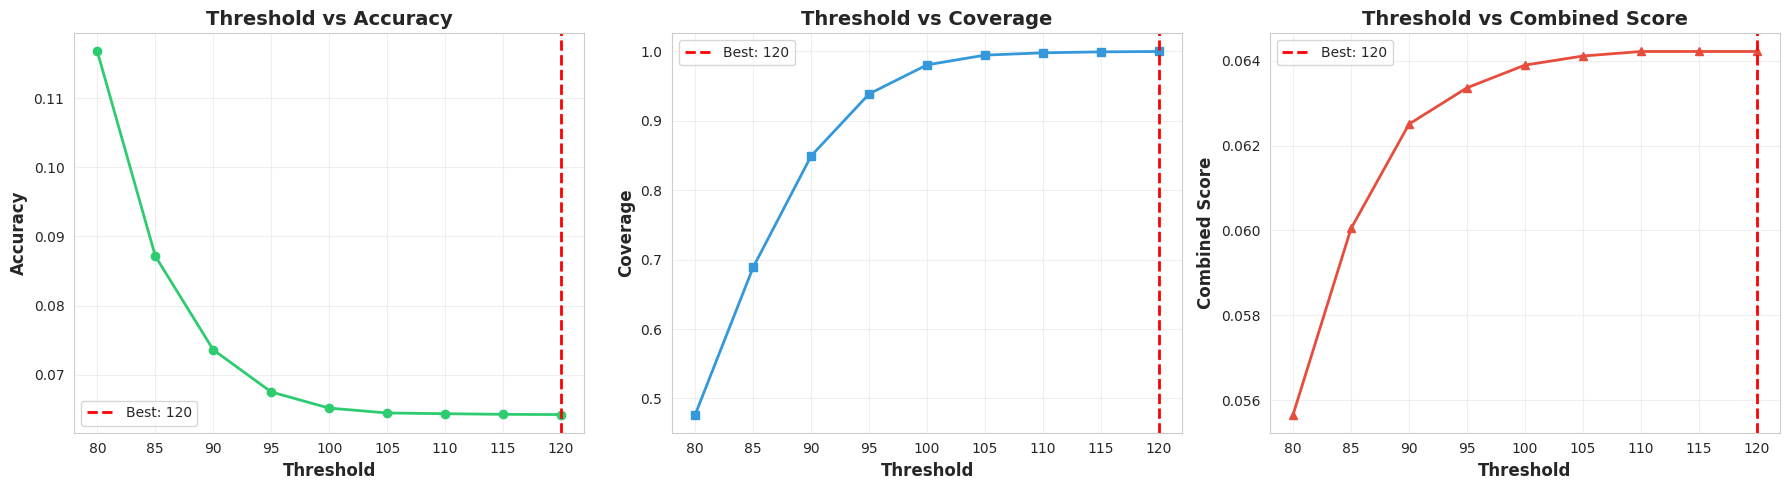

In [21]:
# Vẽ biểu đồ threshold vs metrics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

thresholds = [r[0] for r in threshold_results]
accuracies = [r[1] for r in threshold_results]
coverages = [r[2] for r in threshold_results]
scores = [r[3] for r in threshold_results]

# Plot 1: Threshold vs Accuracy
axes[0].plot(thresholds, accuracies, marker='o', linewidth=2, markersize=6, color='#2ecc71')
axes[0].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best: {best_threshold}')
axes[0].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Threshold vs Accuracy', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Plot 2: Threshold vs Coverage
axes[1].plot(thresholds, coverages, marker='s', linewidth=2, markersize=6, color='#3498db')
axes[1].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best: {best_threshold}')
axes[1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Coverage', fontsize=12, fontweight='bold')
axes[1].set_title('Threshold vs Coverage', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

# Plot 3: Threshold vs Combined Score
axes[2].plot(thresholds, scores, marker='^', linewidth=2, markersize=6, color='#e74c3c')
axes[2].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best: {best_threshold}')
axes[2].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Combined Score', fontsize=12, fontweight='bold')
axes[2].set_title('Threshold vs Combined Score', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=10)

plt.tight_layout()

# Save plot
THRESHOLD_PLOT_PATH = os.path.join(PLOTS_DIR, "threshold_tuning.png")
plt.savefig(THRESHOLD_PLOT_PATH, dpi=150, bbox_inches='tight')
print(f"[OK] Threshold plot saved: {THRESHOLD_PLOT_PATH}")

plt.show()

ANALYZING CONFIDENCE DISTRIBUTION (VALIDATION SET)
Total predictions: 9343
Correct: 600 (6.4%)
Incorrect: 8743 (93.6%)


/tmp/ipykernel_241/3485019719.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)


[OK] Confidence plot saved: /kaggle/working/checkpoints/lbph/plots/confidence_distribution_val.png


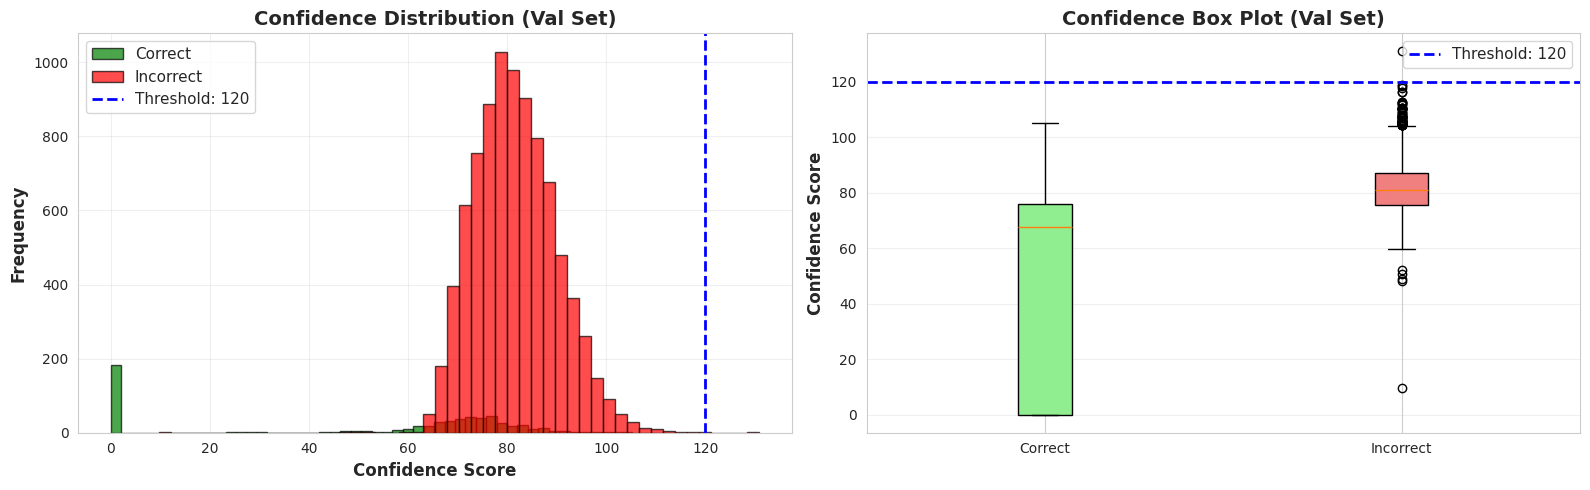

[OK] Confidence stats saved: /kaggle/working/checkpoints/lbph/confidence_stats.json


In [22]:
# Vẽ confidence distribution trên validation set
print("="*60)
print("ANALYZING CONFIDENCE DISTRIBUTION (VALIDATION SET)")
print("="*60)

# Thu thập tất cả predictions và confidences
val_predictions = []
val_confidences_all = []
val_true_labels = []

for i, (face, true_label) in enumerate(zip(val_faces, val_labels)):
    pred_label, confidence = model.predict(face)
    val_predictions.append(pred_label)
    val_confidences_all.append(confidence)
    val_true_labels.append(true_label)

val_confidences_all = np.array(val_confidences_all)
val_predictions = np.array(val_predictions)

# Phân loại correct và incorrect predictions
correct_mask = val_predictions == val_true_labels
correct_confidences = val_confidences_all[correct_mask]
incorrect_confidences = val_confidences_all[~correct_mask]

print(f"Total predictions: {len(val_confidences_all)}")
print(f"Correct: {len(correct_confidences)} ({len(correct_confidences)/len(val_confidences_all)*100:.1f}%)")
print(f"Incorrect: {len(incorrect_confidences)} ({len(incorrect_confidences)/len(val_confidences_all)*100:.1f}%)")

# Vẽ distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Histogram of all confidences
axes[0].hist(correct_confidences, bins=50, alpha=0.7, color='green', label='Correct', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=50, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
axes[0].axvline(best_threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {best_threshold}')
axes[0].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Distribution (Val Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Box plot
data_to_plot = [correct_confidences, incorrect_confidences]
box = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)
box['boxes'][0].set_facecolor('lightgreen')
box['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(best_threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {best_threshold}')
axes[1].set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence Box Plot (Val Set)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save plot
CONFIDENCE_PLOT_PATH = os.path.join(PLOTS_DIR, "confidence_distribution_val.png")
plt.savefig(CONFIDENCE_PLOT_PATH, dpi=150, bbox_inches='tight')
print(f"[OK] Confidence plot saved: {CONFIDENCE_PLOT_PATH}")

plt.show()

# Lưu confidence statistics
confidence_stats = {
    "correct": {
        "mean": float(np.mean(correct_confidences)),
        "std": float(np.std(correct_confidences)),
        "min": float(np.min(correct_confidences)),
        "max": float(np.max(correct_confidences)),
        "median": float(np.median(correct_confidences)),
        "count": int(len(correct_confidences))
    },
    "incorrect": {
        "mean": float(np.mean(incorrect_confidences)),
        "std": float(np.std(incorrect_confidences)),
        "min": float(np.min(incorrect_confidences)),
        "max": float(np.max(incorrect_confidences)),
        "median": float(np.median(incorrect_confidences)),
        "count": int(len(incorrect_confidences))
    },
    "threshold": int(best_threshold)
}

CONFIDENCE_STATS_PATH = os.path.join(CHECKPOINT_DIR, "confidence_stats.json")
with open(CONFIDENCE_STATS_PATH, "w") as f:
    json.dump(confidence_stats, f, indent=2)

print(f"[OK] Confidence stats saved: {CONFIDENCE_STATS_PATH}")

GENERATING CONFUSION MATRIX (VALIDATION SET)
Top 10 classes: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10)]


/tmp/ipykernel_241/4272758804.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


[OK] Confusion matrix saved: /kaggle/working/checkpoints/lbph/plots/confusion_matrix_val.png


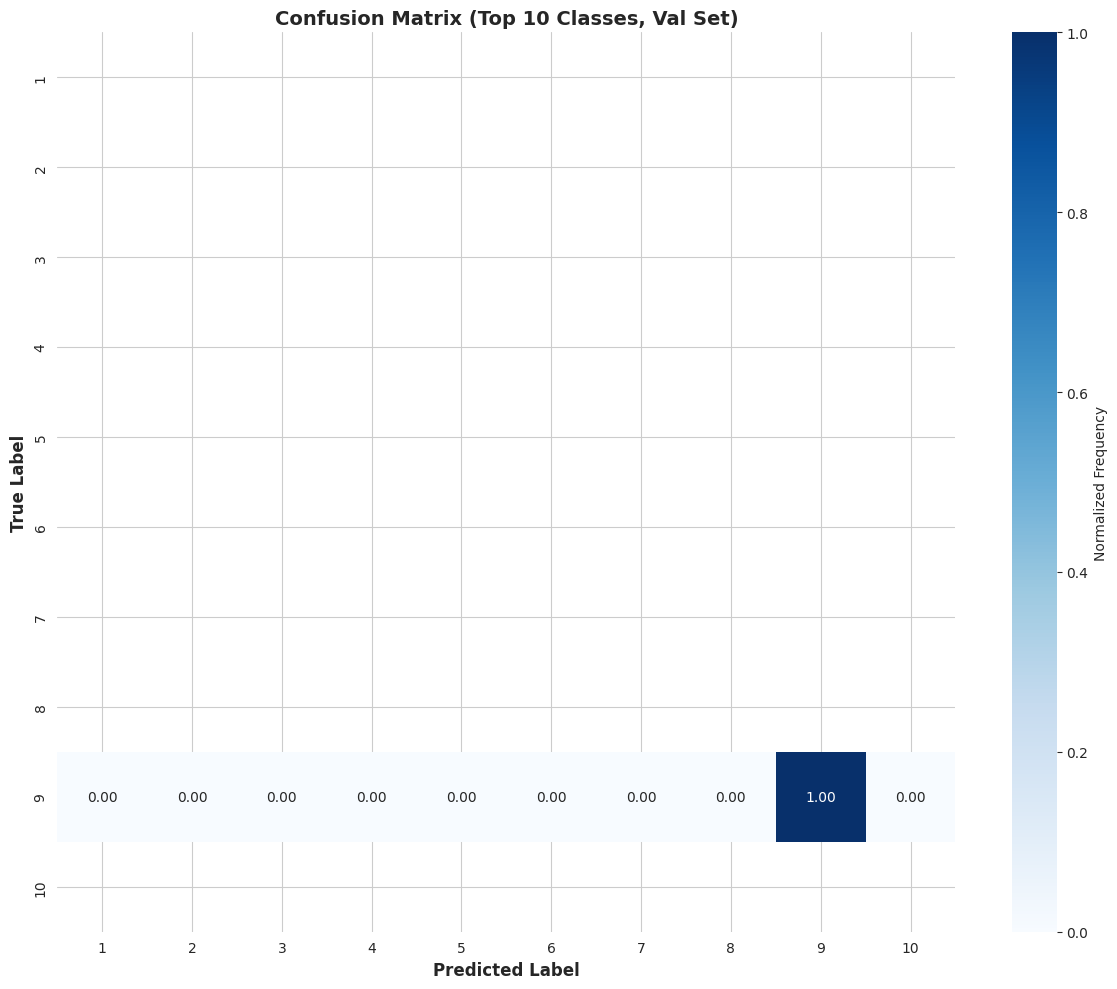

In [23]:
# Vẽ confusion matrix cho top N classes có nhiều samples nhất
from sklearn.metrics import confusion_matrix
import numpy as np

print("="*60)
print("GENERATING CONFUSION MATRIX (VALIDATION SET)")
print("="*60)

# Chọn top N classes có nhiều samples nhất trong val set
from collections import Counter
label_counts = Counter(val_labels)
top_n = 10  # Hiển thị top 10 classes
top_classes = [label for label, count in label_counts.most_common(top_n)]

print(f"Top {top_n} classes: {top_classes}")

# Filter predictions và labels cho top classes
top_mask = np.isin(val_true_labels, top_classes)
top_true = np.array(val_true_labels)[top_mask]
top_pred = val_predictions[top_mask]
# Để đánh giá toàn diện khả năng phân loại của model
print(f"Vẽ confusion matrix cho {len(top_true)} predictions (không filter theo threshold)")

if len(top_true) > 0:
    # Tạo confusion matrix
    cm = confusion_matrix(top_true, top_pred, labels=top_classes)
    
    # Normalize confusion matrix
# Normalize confusion matrix (safe division)
    row_sums = cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.divide(cm.astype('float'), row_sums, 
                              where=row_sums!=0,
                              out=np.zeros_like(cm, dtype=float))    
    # Vẽ confusion matrix
    fig, ax = plt.subplots(figsize=(12, 10))
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=top_classes, yticklabels=top_classes,
                cbar_kws={'label': 'Normalized Frequency'}, ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title(f'Confusion Matrix (Top {top_n} Classes, All Predictions)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
    CM_PLOT_PATH = os.path.join(PLOTS_DIR, "confusion_matrix_val.png")
    plt.savefig(CM_PLOT_PATH, dpi=150, bbox_inches='tight')
    print(f"[OK] Confusion matrix saved: {CM_PLOT_PATH}")
    
    plt.show()
else:
    print("[WARNING] Không có predictions nào cho top classes")


ANALYZING CONFIDENCE DISTRIBUTION (TEST SET)
Total predictions: 9343
Correct: 630 (6.7%)
Incorrect: 8713 (93.3%)


/tmp/ipykernel_241/4153671024.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)


[OK] Test confidence plot saved: /kaggle/working/checkpoints/lbph/plots/confidence_distribution_test.png


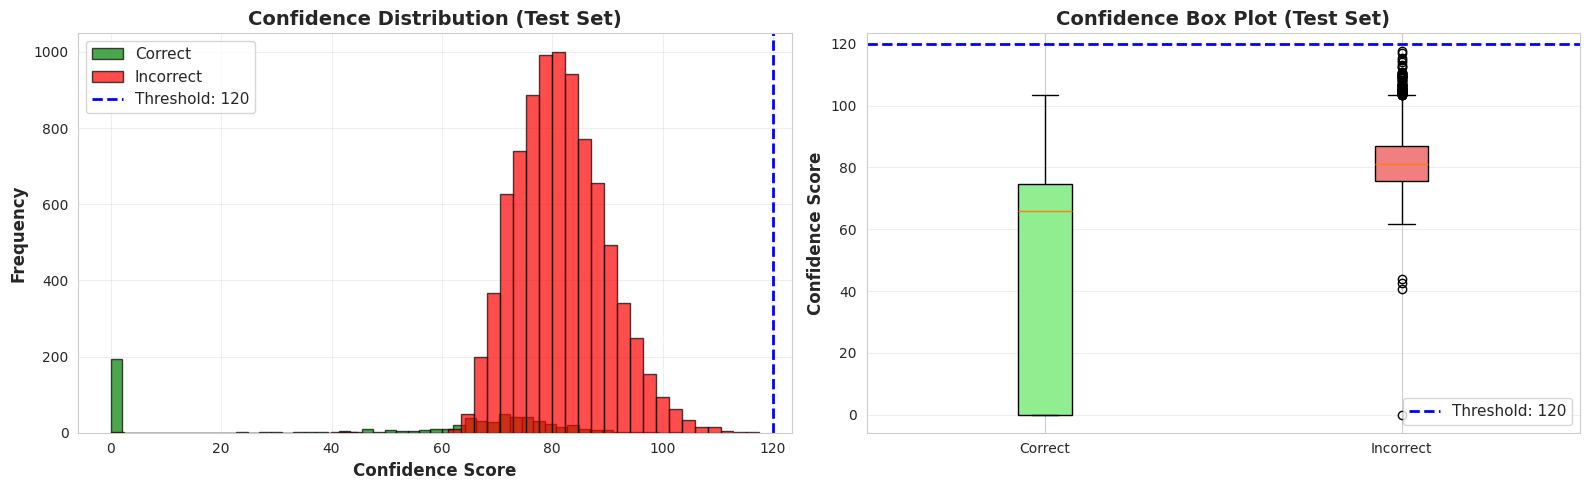

[OK] Test confidence stats saved: /kaggle/working/checkpoints/lbph/test_confidence_stats.json


In [24]:
# Vẽ confidence distribution cho test set
print("="*60)
print("ANALYZING CONFIDENCE DISTRIBUTION (TEST SET)")
print("="*60)

# Thu thập predictions và confidences cho test set
test_predictions = []
test_confidences_all = []
test_true_labels = test_labels.tolist()

for i, (face, true_label) in enumerate(zip(test_faces, test_labels)):
    pred_label, confidence = model.predict(face)
    test_predictions.append(pred_label)
    test_confidences_all.append(confidence)

test_confidences_all = np.array(test_confidences_all)
test_predictions = np.array(test_predictions)

# Phân loại correct và incorrect
test_correct_mask = test_predictions == test_labels
test_correct_confidences = test_confidences_all[test_correct_mask]
test_incorrect_confidences = test_confidences_all[~test_correct_mask]

print(f"Total predictions: {len(test_confidences_all)}")
print(f"Correct: {len(test_correct_confidences)} ({len(test_correct_confidences)/len(test_confidences_all)*100:.1f}%)")
print(f"Incorrect: {len(test_incorrect_confidences)} ({len(test_incorrect_confidences)/len(test_confidences_all)*100:.1f}%)")

# Vẽ histogram
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(test_correct_confidences, bins=50, alpha=0.7, color='green', label='Correct', edgecolor='black')
axes[0].hist(test_incorrect_confidences, bins=50, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
axes[0].axvline(best_threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {best_threshold}')
axes[0].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Distribution (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [test_correct_confidences, test_incorrect_confidences]
box = axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)
box['boxes'][0].set_facecolor('lightgreen')
box['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(best_threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {best_threshold}')
axes[1].set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence Box Plot (Test Set)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save plot
TEST_CONFIDENCE_PLOT_PATH = os.path.join(PLOTS_DIR, "confidence_distribution_test.png")
plt.savefig(TEST_CONFIDENCE_PLOT_PATH, dpi=150, bbox_inches='tight')
print(f"[OK] Test confidence plot saved: {TEST_CONFIDENCE_PLOT_PATH}")

plt.show()

# Lưu test confidence stats
test_confidence_stats = {
    "correct": {
        "mean": float(np.mean(test_correct_confidences)),
        "std": float(np.std(test_correct_confidences)),
        "min": float(np.min(test_correct_confidences)),
        "max": float(np.max(test_correct_confidences)),
        "median": float(np.median(test_correct_confidences)),
        "count": int(len(test_correct_confidences))
    },
    "incorrect": {
        "mean": float(np.mean(test_incorrect_confidences)),
        "std": float(np.std(test_incorrect_confidences)),
        "min": float(np.min(test_incorrect_confidences)),
        "max": float(np.max(test_incorrect_confidences)),
        "median": float(np.median(test_incorrect_confidences)),
        "count": int(len(test_incorrect_confidences))
    },
    "threshold": int(best_threshold)
}

TEST_CONFIDENCE_STATS_PATH = os.path.join(CHECKPOINT_DIR, "test_confidence_stats.json")
with open(TEST_CONFIDENCE_STATS_PATH, "w") as f:
    json.dump(test_confidence_stats, f, indent=2)

print(f"[OK] Test confidence stats saved: {TEST_CONFIDENCE_STATS_PATH}")



## Evaluation on Test Set

Đánh giá model với threshold tìm được trên test set.

## Save Model & Metadata

In [25]:
# Save model checkpoint
import json

MODEL_PATH = os.path.join(CHECKPOINT_DIR, "lbph_model.xml")
METADATA_PATH = os.path.join(CHECKPOINT_DIR, "metadata.json")

# Save model
model.save(MODEL_PATH)
print(f"[OK] Model saved: {MODEL_PATH}")

# Save metadata
metadata = {
    "threshold": int(best_threshold),
    "val_score": float(best_score),
    "test_accuracy": float(test_acc),
    "test_coverage": float(test_cov),
    "num_classes": int(len(np.unique(train_labels))),
    "train_images": int(len(train_faces)),
    "val_images": int(len(val_faces)),
    "test_images": int(len(test_faces)),
    "model_params": {
        "radius": 1,
        "neighbors": 8,
        "grid_x": 8,
        "grid_y": 8
    }
}

with open(METADATA_PATH, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"[OK] Metadata saved: {METADATA_PATH}")
print("\nMetadata:")
print(json.dumps(metadata, indent=2))

[OK] Model saved: /kaggle/working/checkpoints/lbph/lbph_model.xml
[OK] Metadata saved: /kaggle/working/checkpoints/lbph/metadata.json

Metadata:
{
  "threshold": 120,
  "val_score": 0.06421920154126085,
  "test_accuracy": 0.06743016161832388,
  "test_coverage": 1.0,
  "num_classes": 9343,
  "train_images": 9343,
  "val_images": 9343,
  "test_images": 9343,
  "model_params": {
    "radius": 1,
    "neighbors": 8,
    "grid_x": 8,
    "grid_y": 8
  }
}


## Download Checkpoint

Zip checkpoint folder để download.

In [26]:
# Zip checkpoint folder để download
import shutil

zip_name = "lbph_checkpoints"
zip_path = f"/kaggle/working/{zip_name}"

shutil.make_archive(zip_path, "zip", CHECKPOINT_DIR)

print(f"[OK] Da tao file zip: {zip_path}.zip")
print(f"\nDownload file nay tu panel Output ben phai.")
!ls -lh /kaggle/working/*.zip

[OK] Da tao file zip: /kaggle/working/lbph_checkpoints.zip

Download file nay tu panel Output ben phai.
-rw-r--r-- 1 root root 59M Dec 19 03:16 /kaggle/working/lbph_checkpoints.zip
